## Hack on ELAsTiCC Light Curve Physics
_Alex Gagliano and Benjamin Remy_
#### This jupyter notebook provides a simple example of how physical parameters (the mass of radioactive nickel produced, the time of explosion, and the ejecta timescale of radiative diffusion) are extracted from supernova photometry.
We'll use a supernova from the Extended LSST Astronomical Time-Series Classification Challenge (ELAsTiCC) for our analysis.

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import special
import emcee
from scipy.optimize import minimize
import time
import corner

First, we add some code to style our plots:

In [4]:
def stylePlots():
    """A quick function to make subsequent plots look nice (requires seaborn).
    """
    sns.set_context("talk",font_scale=1.25)

    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15

    plt.rcParams['xtick.minor.size'] = 10
    plt.rcParams['ytick.minor.size'] = 10
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2

    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['ytick.left'] = True
    plt.rcParams['ytick.right'] = True

    plt.rcParams['xtick.minor.visible'] = True
    plt.rcParams['ytick.minor.visible'] = True
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    plt.rcParams.update({
        #"text.usetex": True,turn off for now, not sure where my latex went
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    })
    
stylePlots()

Next, we read in a data file that contains photometry and host-galaxy properties for 5,000 SNe Ia in the training set for the ELAsTiCC challenge. 

In [5]:
df = pd.read_json("ELAsTiCC_SNe_5k.json")

Let's plot the data for one supernova:

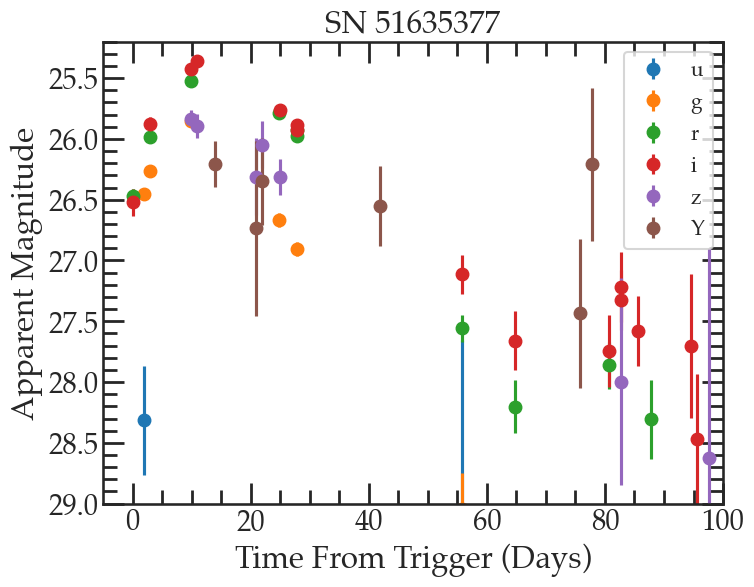

In [6]:
#Plot one supernova across all bands 
zp = 31.5

chosen_idx = 15

t0 = df['MJD_TRIGGER'].values[chosen_idx]
t = np.array(df['MJD'].values[chosen_idx]) - t0
mag = np.array(df['MAG'].values[chosen_idx])
magerr = np.array(df['MAGERR'].values[chosen_idx])

#floor the values that are missing
magerr[magerr == None] = 1.0
mag[mag == None] = zp

bands = np.array(df['Filter'].values[chosen_idx])
photo_z = df['HOSTGAL_PHOTOZ'].values[chosen_idx]
mwebv = df['MWEBV'].values[chosen_idx]
name = df['SNID'].values[chosen_idx]

band_list = 'ugrizY'

plt.figure(figsize=(8,6))
for band in band_list:
    idx = band == bands 
    plt.errorbar(t[idx], mag[idx], fmt='o', yerr=magerr[idx], label=band)

plt.ylim((29, 25.2))
plt.xlim(-5, 100)

plt.xlabel("Time From Trigger (Days)")
plt.ylabel("Apparent Magnitude")
plt.title("SN %s"%name)

plt.legend(fontsize=15);

In order to understand how the supernova physics evolves in time, we first have to create an underlying representation of its observed behavior. We do this by building a gaussian process model, and interpolating the photometry in each passband onto the same uniformly-sampled grid in time:

In [7]:
interpolated_DF = pd.read_csv("/Users/alexgagliano/Documents/Conferences/desc_feb23/superbol/SN51635377_ugrizY.txt", sep=' ')

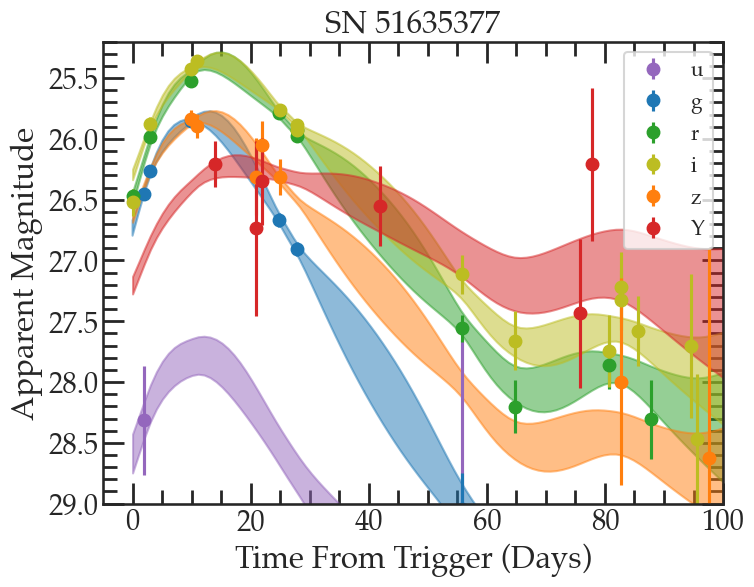

In [8]:
#interpolated light curves 
colset = sns.color_palette()
cols_bands = [colset[4], colset[0], colset[2], colset[8], colset[1], colset[3]]
    
plt.figure(figsize=(8,6))
for i in np.arange(len(band_list)):
    band = band_list[i]
    idx = band == bands 
    plt.fill_between(interpolated_DF['t'], interpolated_DF['%s'%band]-interpolated_DF['%s_err'%band], interpolated_DF['%s'%band]+interpolated_DF['%s_err'%band],  color=cols_bands[i], alpha=0.5)
    plt.errorbar(t[idx], mag[idx], fmt='o', yerr=magerr[idx], label=band, color=cols_bands[i])
    
plt.ylim((29, 25.2))
plt.xlim(-5, 100)

plt.xlabel("Time From Trigger (Days)")
plt.ylabel("Apparent Magnitude")
plt.title("SN %s"%name)

plt.legend(fontsize=15);

Not a terrible model, although you can tell our data for Y-band is noisy and our data for u-band quickly gets very faint. We might not want to trust this model after ~30 days or so. For now, I've taken the photometry at each phase and fit them to a blackbody curve (after k-correcting and accounting for simulated extinction and time dilation). I can integrate this blackbody curve to estimate the bolometric luminosity as a function of time. This looks like the following:

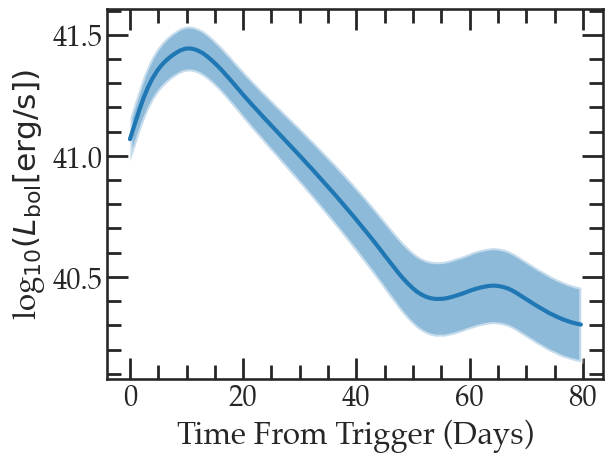

In [25]:
df_interp = pd.read_csv("/Users/alexgagliano/Documents/Conferences/desc_feb23/superbol/superbol_output_SN51635377/logL-bb_SN51635377_ugrizY.txt", sep='\t', header=None, names=['phase', 'logL', 'logLerr'])
plt.plot(df_interp['phase'], df_interp['logL'], '-', lw=3)
plt.fill_between(df_interp['phase'], df_interp['logL']-df_interp['logLerr'], df_interp['logL']+df_interp['logLerr'], lw=3,alpha=0.5)


plt.xlabel("Time From Trigger (Days)")
plt.ylabel(r"log$_{10}(L_{\rm bol} \left[\rm{erg/s}\right])$");

Now we fit this light curve to a physical model. We use the treatment from Arnett et al. (1982), which assumes that the emission from the supernova is caused by the radioactive decay of $^{56}$Ni into $^{56}$Co, and then $^{56}$Co into $^{56}$Fe. Note that this assumes that the observed luminosity is equal to the rate of radioactive heating at peak! This is not necessarily the case (particularly for dense heating sources as with the explosion of a small white dwarf), but as a first pass the model works well. We set up the relevant equations:

In [10]:
#some constants
tauNi = 8.77 #decay timescale of nickel, in days
tauCo = 111.3 #decay timescale of cobalt, in days

#energy injection through Nickel and Cobalt decay
epsNi = 3.9E10
epsCo = 6.78E9

#Mass of the sun in grams
MSun = 2E33

#def variables/functions
#tau is the diffusion timescale and MNi is the total mass of nickel
def term1(tau):
    return tau/(2*tauNi)

def term2(tau):
    return tau * (tauCo - tauNi) / (2 * tauNi * tauCo)

def A(t, tau):
    return np.exp(-(term1(tau)**2)) * (np.sqrt(np.pi) * term1(tau) * special.erfi(t/tau - term1(tau)) + np.sqrt(np.pi) * term1(tau) * special.erfi(term1(tau)) + np.exp((t/tau - term1(tau))**2) - np.exp(term1(tau)**2))

def B(t, tau):
    return np.exp(-(term2(tau) - term1(tau))**2) * (np.sqrt(np.pi) * (term2(tau) - term1(tau)) * (special.erfi(term2(tau) - term1(tau)) - special.erfi(term2(tau) + t/tau - term1(tau))) + np.exp((term2(tau) + t/tau - term1(tau))**2) - np.exp((term2(tau) - term1(tau))**2))

def L(t, tau, MNi):
    return ((MNi*MSun) * np.exp(-(t/tau)**2) * ((epsNi - epsCo) * A(t, tau) +  B(t, tau)))

Next, we define the equations we'll need for a markov chain exploration of our parameter space. We'll start off with an initial guess that the supernova exploded when the first non-zero photometric measurement was taken ($dt = 0$). We also define the diffusion timescale and the mass (in solar masses) of radioactive Nickel created in the explosion. We'll set broad and flat priors for these parameters. 

One more thing is that we'll only look at fitting the photometry in the first 30 days. This is both because the assumption of constant opacity starts to break down around here, and also because we could see from our gaussian process model that we might not trust the u-band model beyond 30 days. 

In [26]:
def log_likelihood(theta, tobs, yobs, yerr):
    log_like_sum = 0
    dt, tdiff, MNi = theta
    return -0.5 * np.sum((yobs - L(tobs+dt, tdiff, MNi)) ** 2 / yerr**2)

def log_prior(theta):
    dt, tdiff, MNi = theta
    if 0 < dt < 10 and 7 < tdiff < 25 and 1.e-2 < MNi < 1.e-1:
        return 0.0
    return -np.inf

def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

dt = 0.0 #days
tdiff = 10. #days
MNi = 0.05 #Msol
theta = [dt, tdiff, MNi]

#take the first interpolated observation
t = df_interp['phase'].values
y = 10**df_interp['logL'].values
yerr = 2.303 * df_interp['logLerr'].values * y #error propagation!

#trim before opacity effects become important!
y = y[t < 30]
yerr = yerr[t < 30]
t = t[t < 30]

nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, theta, args=(t, y, yerr), bounds=[(0, 10), (7, 25), (1.e-2, 1.e-1)])

pos = soln.x + soln.x* 1.e-1*np.random.randn(64, 3)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(t, y, yerr)
)
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
time_spanned = end - start

  0%|                                                                                                            | 0/10000 [00:00<?, ?it/s]/Users/alexgagliano/mambaforge/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:49<00:00, 200.65it/s]


Looking at the chains:

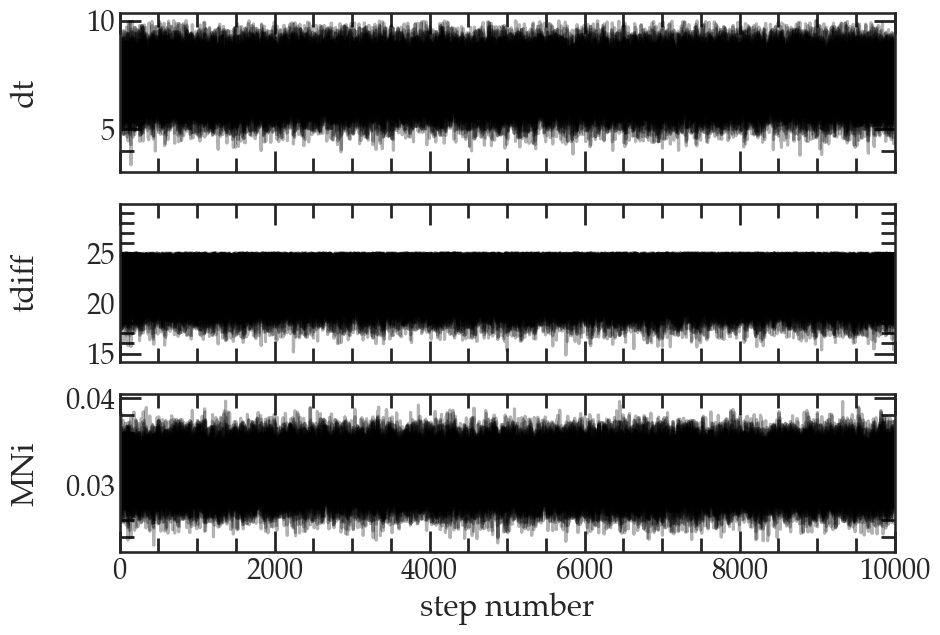

In [27]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["dt", "tdiff", "MNi"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

And now making a corner plot of our results: 

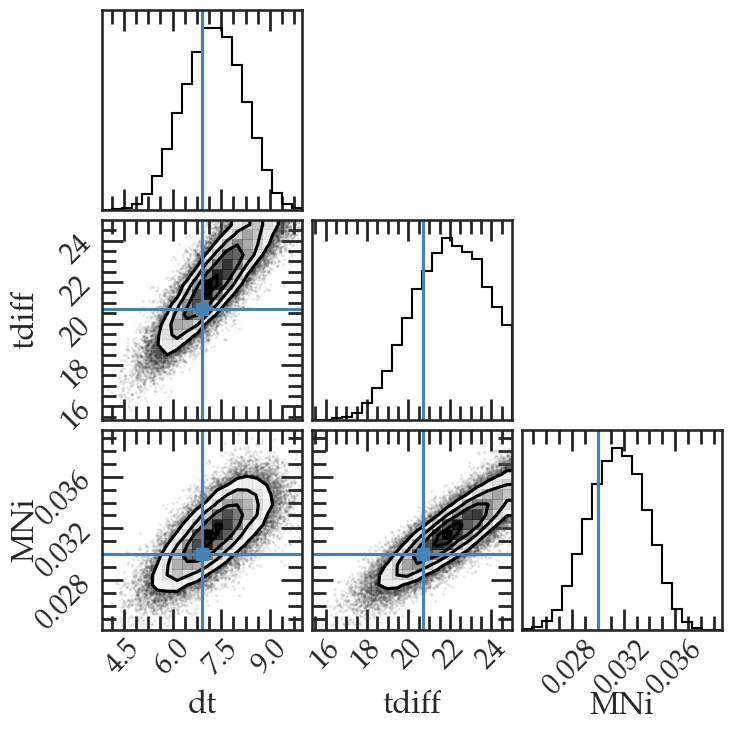

In [32]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[6.9, 20.7, 0.03]
);

Here our "truth" values were determined by a grid serach of the parameter space. The parameters all look a little over-estimated here, but as we'll see below, the uncertainties are pretty high for our interpolated luminosity. Taking the best-fit values: 

In [33]:
dt = np.percentile(flat_samples[:, 0], [50])[0]
tdiff =  np.percentile(flat_samples[:, 1], [50])[0]
MNi =  np.percentile(flat_samples[:, 2], [50])[0]

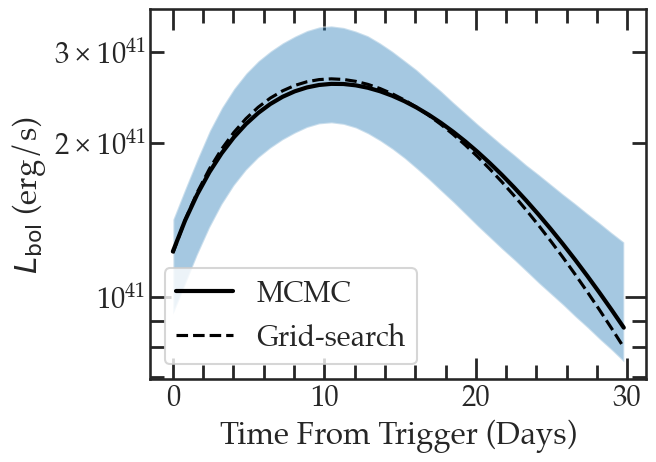

In [41]:
plt.plot(t, L(t+dt, tdiff, MNi), zorder=100, lw=3, c='k', label='MCMC')
plt.plot(t, L(t+6.9, 20.7, 0.03), zorder=100, ls='--', c='k', label='Grid-search')
plt.fill_between(t, y-yerr, y+yerr, alpha=0.4)
plt.xlabel("Time From Trigger (Days)")
plt.ylabel(r"$L_{\rm bol}$ (erg/s)")
plt.yscale("log");
plt.legend();

In [42]:
print("Amount of time elapsed by the MCMC: %.2f sec."% time_spanned)

Amount of time elapsed by the MCMC: 49.86 sec.


Both answers are well within the uncertainties! Now, can we speed this up with jax and/or flowMC?